In [ ]:
#Useful Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, train_test_split


**REMOVING NULL VALUES**

In [ ]:
#Importing Dataset, identifying null values and filling them

housingdataset = pd.read_csv('housing.csv')
housingdataset['ocean_proximity'].unique()
housingdataset.isnull().sum()
bedfill = housingdataset['total_bedrooms'].mean()
housingdataset['total_bedrooms'] = housingdataset['total_bedrooms'].fillna(bedfill)
housingdataset["rooms_per_household"] = housingdataset["total_rooms"] / housingdataset["households"]
housingdataset["bedrooms_per_room"] = housingdataset["total_bedrooms"] / housingdataset["total_rooms"]
housingdataset["population_per_household"] = housingdataset["population"] / housingdataset["households"]


**ENCODING**

In [ ]:
#Only one feature ocean_proximty needed encoding(one hot encoding because data was nominal)

oe = OneHotEncoder(sparse_output=False)
encoded = oe.fit_transform(housingdataset[['ocean_proximity']])
columnname = oe.get_feature_names_out(['ocean_proximity'])
encodeddf = pd.DataFrame(encoded, columns = columnname)
housingdataset = housingdataset.drop('ocean_proximity', axis = 1)
housingdataset = pd.concat([encodeddf,housingdataset], axis =1 )


In [ ]:
housingdataset.columns

Index(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'longitude', 'latitude',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household'],
      dtype='object')

**OUTLIERS REMOVAL**

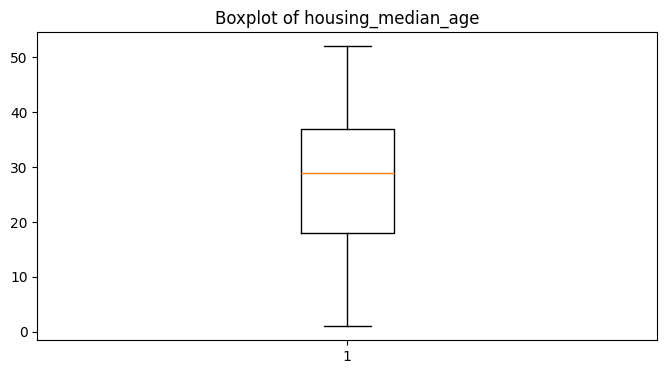

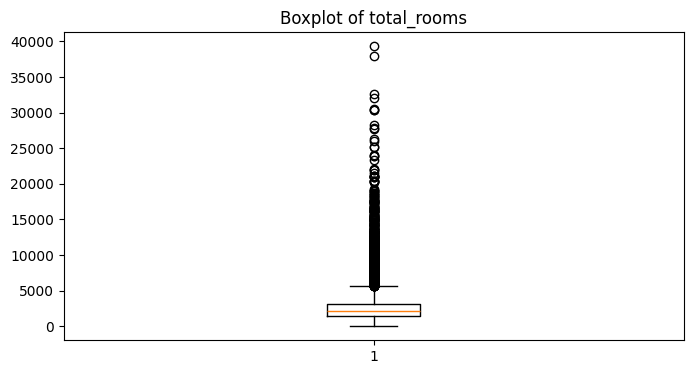

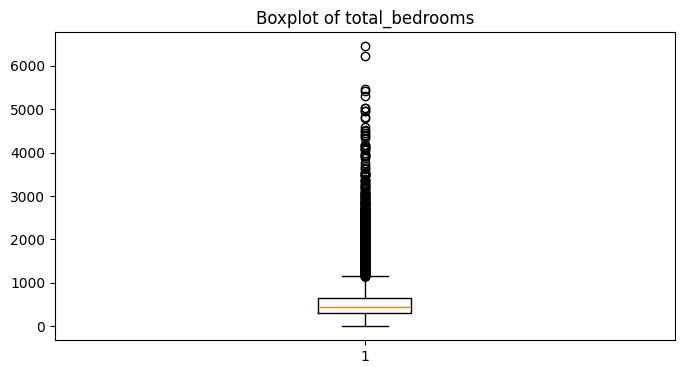

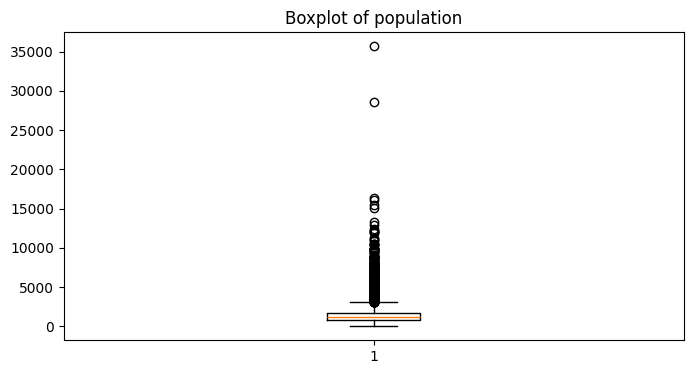

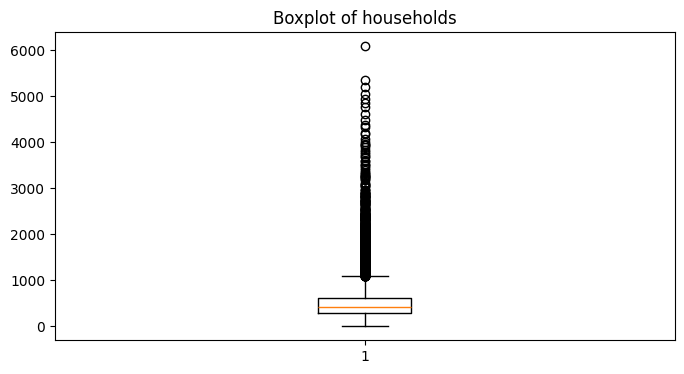

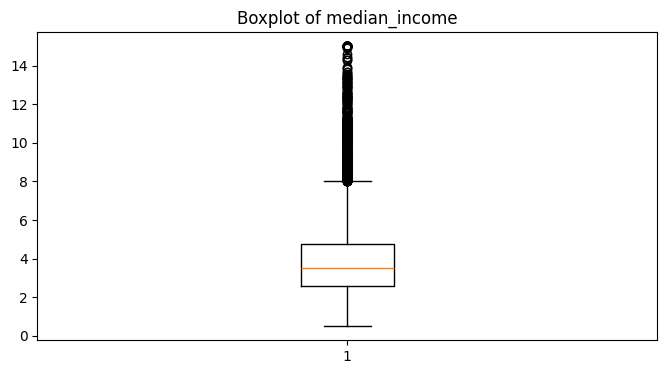

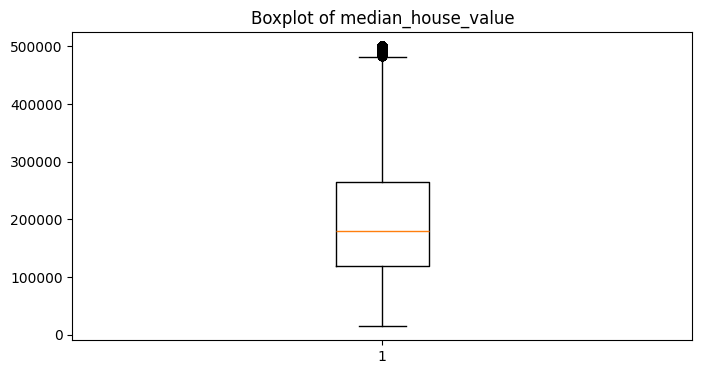

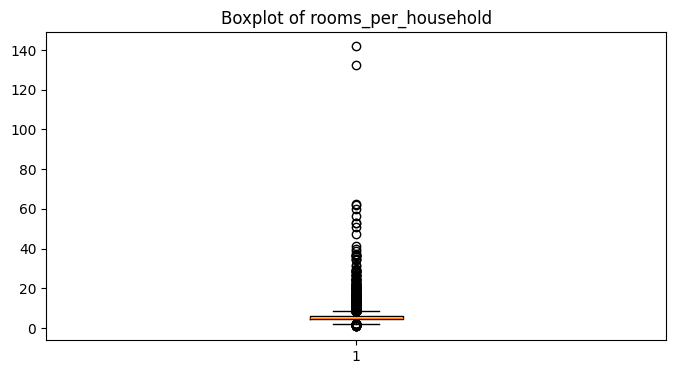

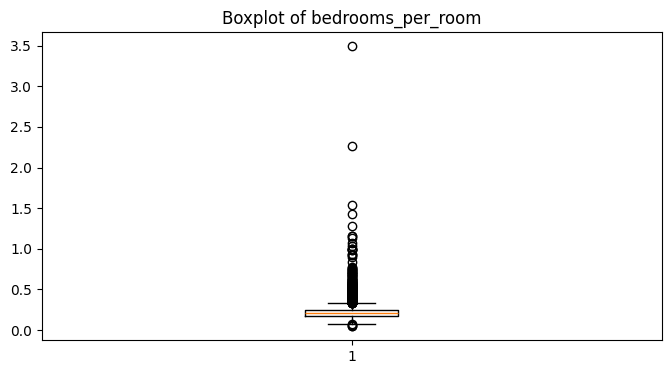

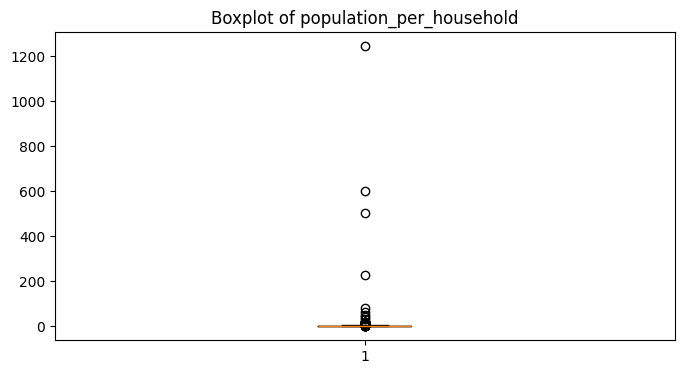

In [ ]:
#boxplot for all numeric columns to visualize outliers
numerical_cols = ['housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income', 'median_house_value','rooms_per_household', 'bedrooms_per_room', 'population_per_household']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    plt.boxplot(housingdataset[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [ ]:
#Removing Outliers using IQR METHOD, 3 is used as data is more skewed
outlier_indices = set()
for col in ['housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income', 'median_house_value','rooms_per_household', 'bedrooms_per_room', 'population_per_household']:
    Q1 = housingdataset[col].quantile(0.25)
    Q3 = housingdataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = housingdataset[(housingdataset[col] < lower_bound) | (housingdataset[col] > upper_bound)].index
    outlier_indices.update(outliers)

housingdataset.drop(index=outlier_indices, inplace=True)

**SCALING**

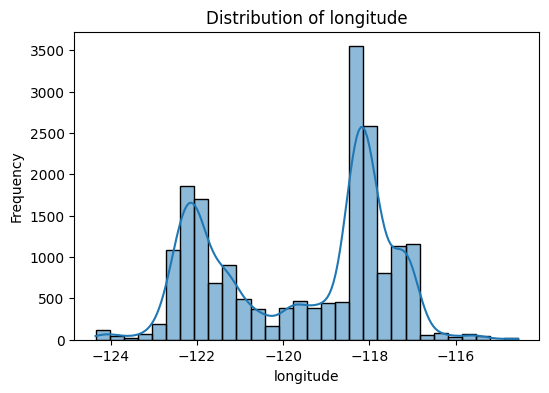

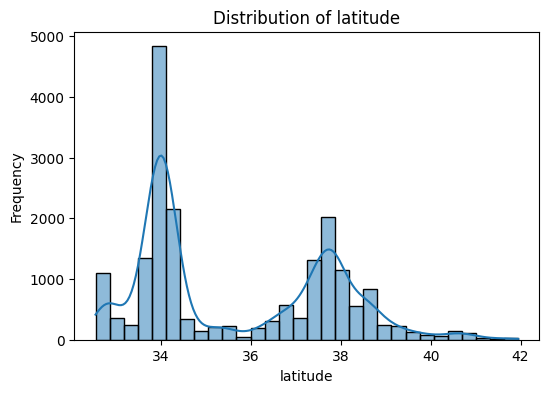

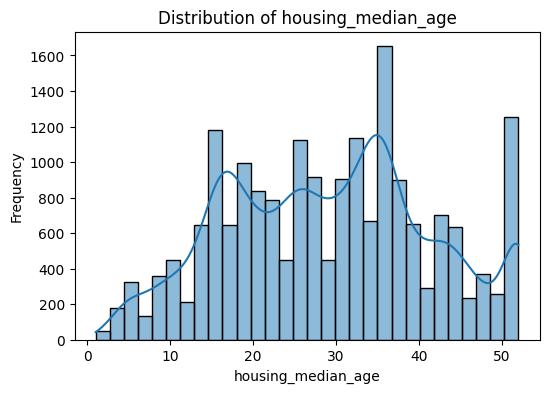

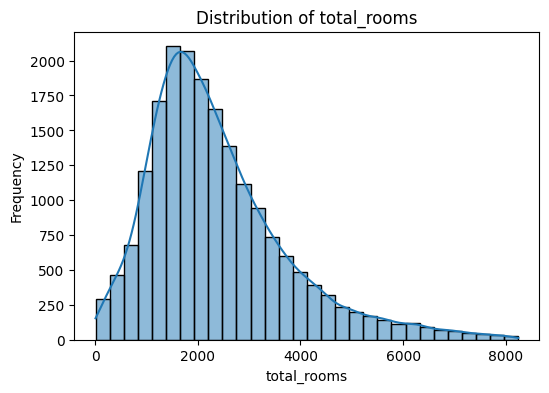

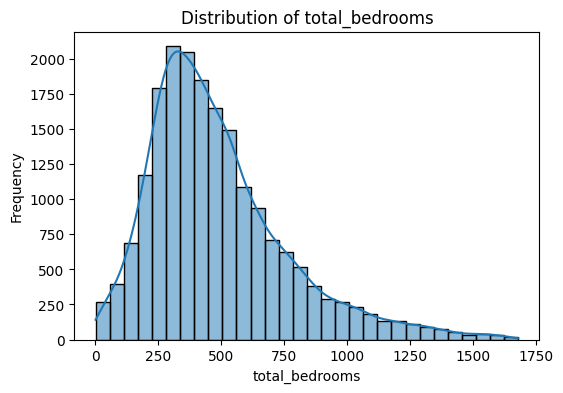

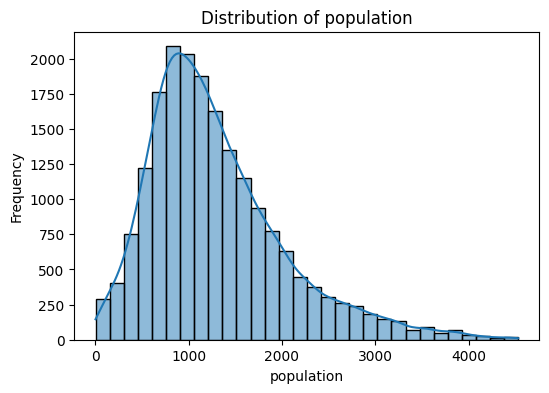

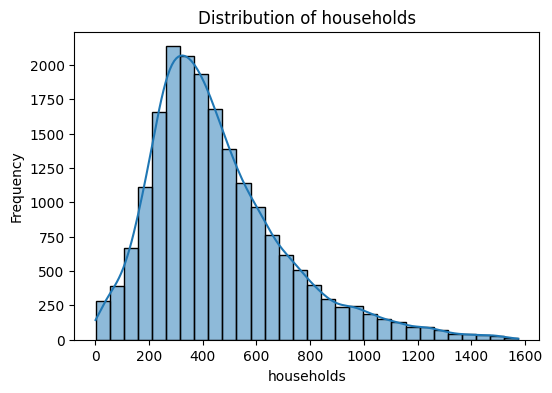

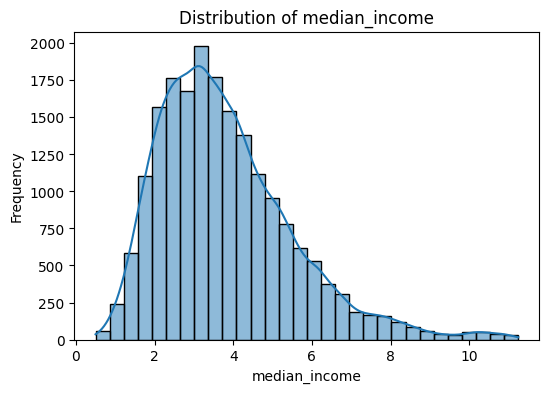

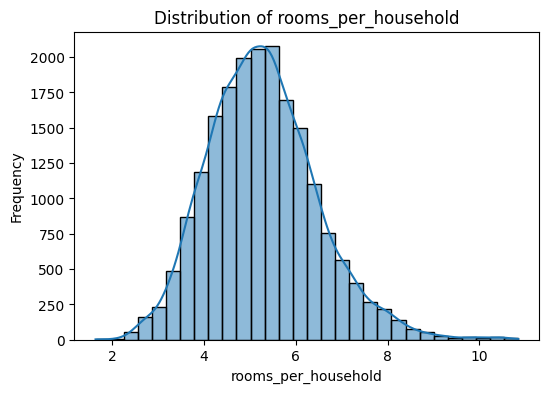

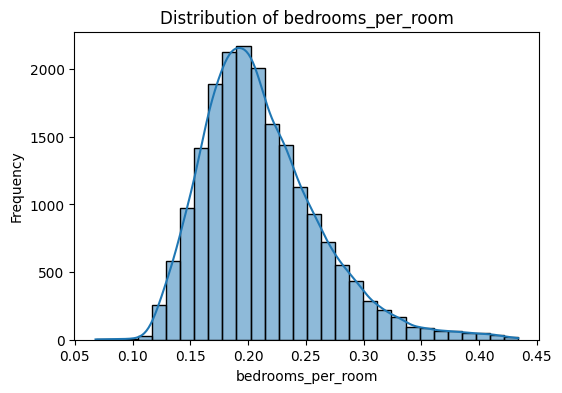

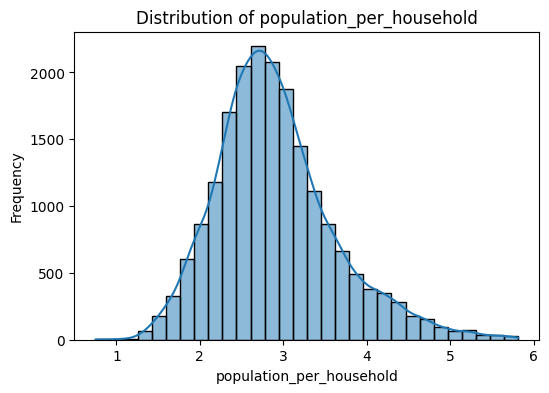

In [ ]:
# histplots so i can see which ones can be scaled using standard scalar(normal distribution) or minmax scalar(non normal distribution)
columns = [
    'longitude', 'latitude',
    'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
    'households', 'median_income','rooms_per_household', 'bedrooms_per_room', 'population_per_household'
]

for col in columns:
    plt.figure(figsize=(6,4))
    sns.histplot(housingdataset[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
#looking at histplots i will be using
# STANDARD SCALAR ON total_room,total_bedrooms,population,household,median income
# MINMAX SCALAR ON longitude,latitude,housingmedianage
standard_cols = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income','rooms_per_household', 'bedrooms_per_room', 'population_per_household']
minmax_cols = ['longitude', 'latitude', 'housing_median_age']
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
# for below lines you can use loop as well or this will still work
housingdataset[standard_cols] = std_scaler.fit_transform(housingdataset[standard_cols])
housingdataset[minmax_cols] = minmax_scaler.fit_transform(housingdataset[minmax_cols])

**FEATURE SELECTION**

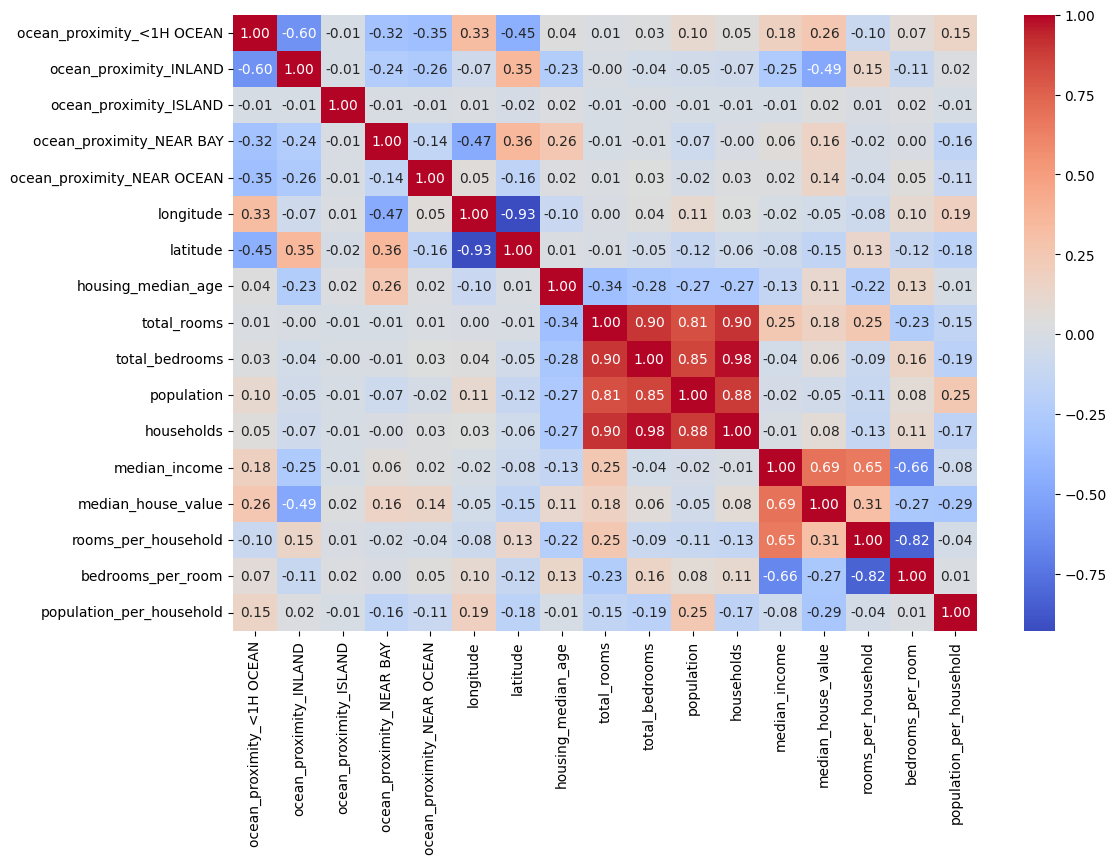

In [ ]:
# heatmap to visualize correlation matrix, correlation >0.3 stronger , between 0.1 - 0.3 weak but maybe useful , <0.1 very weak choose some
corr_matrix = housingdataset.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.show()

In [ ]:
# after observing heatmap ,the folliwing features maybe helpful ocean_proximity_< 1H OCEAN,ocean_proximity_INLAND,median_income,rooms_per_household,bedrooms_per_room,population_per_household
#x = housingdataset[['ocean_proximity_<1H OCEAN','ocean_proximity_INLAND','total_rooms','median_income']]
# but i still went for other ways to check for best features like sequencefeatureselector and Lasso and found all the features somehow useful
x = housingdataset.drop('median_house_value', axis=1)
y = housingdataset['median_house_value']

In [ ]:
lr = LinearRegression()

In [ ]:
#i tested various estimators to check for best features , Linear Regression and Decsion Tree Regressor
estimators = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}
from mlxtend.feature_selection import SequentialFeatureSelector

for name, model in estimators.items():
    print(f"\nEstimator: {name}")
    for k in range(1, 17):
        sfs = SequentialFeatureSelector(model,
                                        k_features=k,
                                        forward=True,
                                        scoring='r2',   # 'accuracy' if classification
                                        cv=5)
        sfs.fit(x, y)
        print(f"Features: {k}, {sfs.k_feature_names_}, Score: {sfs.k_score_:.4f}")


Estimator: Linear Regression
Features: 1, ('median_income',), Score: 0.4177
Features: 2, ('ocean_proximity_INLAND', 'median_income'), Score: 0.5445
Features: 3, ('ocean_proximity_INLAND', 'median_income', 'population_per_household'), Score: 0.5988
Features: 4, ('ocean_proximity_INLAND', 'median_income', 'bedrooms_per_room', 'population_per_household'), Score: 0.6145
Features: 5, ('ocean_proximity_INLAND', 'housing_median_age', 'median_income', 'bedrooms_per_room', 'population_per_household'), Score: 0.6240
Features: 6, ('ocean_proximity_INLAND', 'housing_median_age', 'total_bedrooms', 'median_income', 'bedrooms_per_room', 'population_per_household'), Score: 0.6269
Features: 7, ('ocean_proximity_INLAND', 'housing_median_age', 'total_bedrooms', 'population', 'median_income', 'bedrooms_per_room', 'population_per_household'), Score: 0.6277
Features: 8, ('ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'housing_median_age', 'total_bedrooms', 'population', 'median_income', 'bedrooms_per_


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)


**TRAIN_TEST SPLIT**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y)
xp_train, xp_test, yp_train, yp_test = train_test_split(x_poly,y)

**Lasso Test to select best features**

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
la = LassoCV(alphas=[0.01, 0.1, 1, 10, 50, 100, 200, 500, 1000], cv=5, random_state=42 )
la.fit(x_train,y_train)
print("Best alpha:", la.alpha_)
selected_features = x_train.columns[(la.coef_ != 0)]
print("Selected features:", list(selected_features))

Best alpha: 1.0
Selected features: ['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN', 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+12, tolerance: 1.901e+10
  model = cd_fast.enet_coordinate_descent(


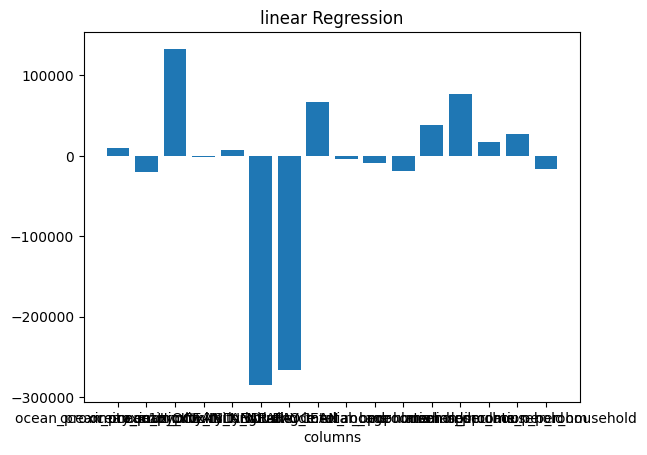

In [ ]:
plt.bar(x.columns,la.coef_)
plt.title("linear Regression")
plt.xlabel("columns")
plt.show()

**MODEL TRAINING**

**Decision Tree with hyper Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
dt = DecisionTreeRegressor(random_state=42)


param_dist = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [None, 'sqrt', 'log2']
}


random_search = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)


random_search.fit(x_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


best_dt = random_search.best_estimator_
print("Test R2:", best_dt.score(x_test, y_test))


Best parameters: {'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(17), 'max_features': None, 'max_depth': None}
Best score: 0.7280621113801019
Test R2: 0.7432686900801804


**Polynomial Regression with Degree = 3**

In [ ]:
pr = LinearRegression()
pr.fit(xp_train,yp_train)
pr.score(xp_train, yp_train) ,pr.score(xp_test, yp_test)

(0.8075420573842897, 0.7664394655631779)

**Ensemble Voting Regressor**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor


lr = LinearRegression()


poly = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())


dt = DecisionTreeRegressor(random_state=42)


voting_reg = VotingRegressor(
    estimators=[
        ('linear', lr),
        ('poly', poly),
        ('tree', dt)
    ]
)


voting_reg.fit(x_train, y_train)

y_pred = voting_reg.predict(x_test)


from sklearn.metrics import r2_score, mean_squared_error

print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R2 Score: 0.7645704947090771
MSE: 2930844707.1142025


**Random Forest Regressor (Best Model)**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(random_state=42, n_jobs=-1)


param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)


grid_search.fit(x_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best CV R2 Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
print("Train R2:", best_rf.score(x_train, y_train))
print("Test R2:", best_rf.score(x_test, y_test))




Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best CV R2 Score: 0.8116961953702262
Train R2: 0.9722983143452213
Test R2: 0.820539718308686
